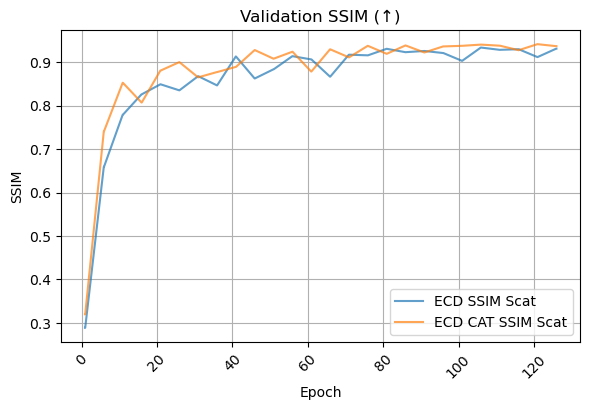

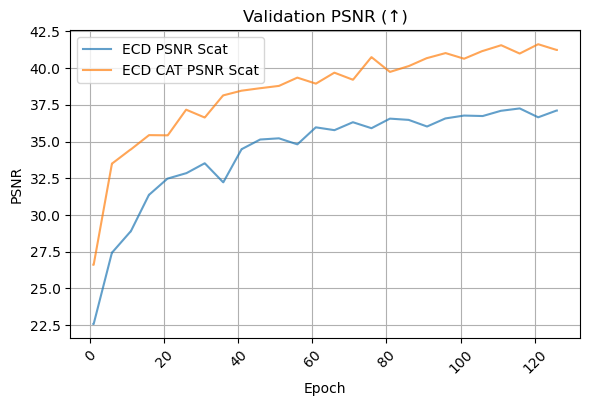

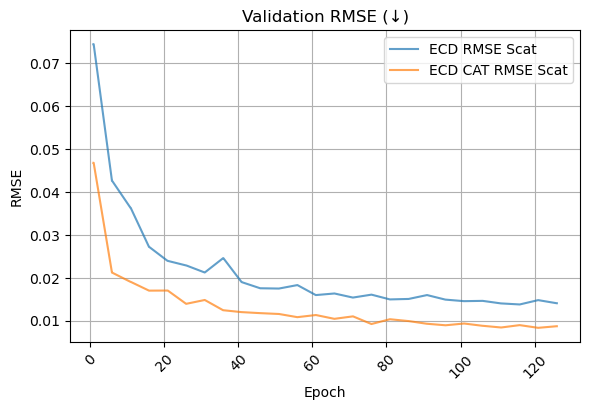

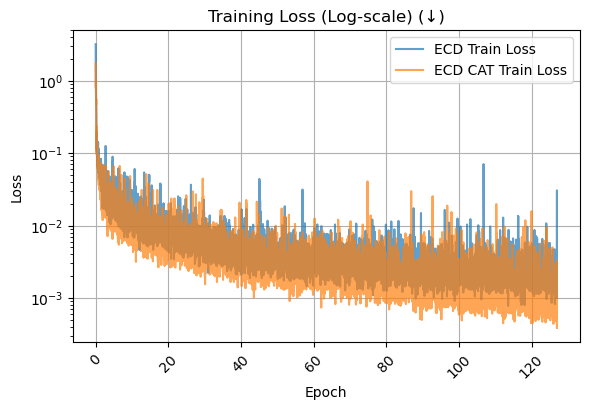

In [38]:
# Some scripts to read CSVs exported from WandB and we'll plot them using matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = '../data/'

def get_csv_data(file_path, x_col_name='Step', y_col_name='value', step_conversion: np.ndarray|None=None, averaging_width: int|None=None) -> np.ndarray:
    """
    Reads a CSV file using pandas / numpy and returns the data as a numpy array.
    We can specify which columns to use as the x and y axes.
    """
    df: pd.DataFrame = pd.read_csv(file_path)
    if x_col_name not in df.columns or y_col_name not in df.columns:
        raise ValueError(f"Columns '{x_col_name}' or '{y_col_name}' not found in the CSV file.")
    x_data = df[x_col_name].values
    y_data = df[y_col_name].values

    assert len(x_data) == len(y_data), "X and Y data lengths do not match."

    if averaging_width is not None:
        starting_x = x_data[0]
        accum_y = [y_data[0]]
        for i in range(1, len(x_data)+1):
            if i < len(x_data) and x_data[i] - starting_x < averaging_width:
                accum_y.append(y_data[i])
            else:
                avg_y = np.mean(accum_y.copy())
                for j in range(i-1, i-1 - len(accum_y), -1):
                    y_data[j] = avg_y
                if i < len(x_data):
                    # Reset for the next averaging window
                    starting_x = x_data[i]
                    accum_y = [y_data[i]]
        
    if step_conversion is not None:
        # If step_conversion is provided, we assume it is a mapping from steps to some other values
        # e.g., epochs or time
        # For each x_data value, we find the step_conversion y value that falls in the range of step_conversion's x values
        x_data = np.interp(x_data, step_conversion[:, 0], step_conversion[:, 1])

    return np.column_stack((x_data, y_data))

def plot_data(data: dict[np.ndarray], x_label: str = 'Step', y_label: str = 'Value', title: str = 'Plot', log_scale: bool=False):
    """
    Plots the data from a dictionary of numpy arrays.
    Each key in the dictionary is a label for the plot.
    """
    plt.figure(figsize=(6, 4))
    for label, values in data.items():
        plt.plot(values[:, 0], values[:, 1], label=label, alpha=0.7)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if log_scale:
        plt.yscale('log')
    else:
        plt.yscale('linear')
    plt.xscale('linear')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


# Plot the data
data_step_epoch = get_csv_data(data_dir + 'step-epoch.csv', x_col_name='Step', y_col_name='woven-puddle-82 - train/epoch')

# Plot Validation SSIM for Scatter, between ECD and ECD-CAT
data_ECD_ssim_scat = get_csv_data(data_dir + 'ECD-ssim-scat.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - val/ssim_scat', step_conversion=data_step_epoch, averaging_width=100)
data_ECD_CAT_ssim_scat = get_csv_data(data_dir + 'ECD-CAT-ssim-scat.csv', x_col_name='Step', y_col_name='woven-puddle-82 - val/ssim_scat', step_conversion=data_step_epoch, averaging_width=100)

plot_data({
    'ECD SSIM Scat': data_ECD_ssim_scat,
    'ECD CAT SSIM Scat': data_ECD_CAT_ssim_scat,
}, x_label='Epoch', y_label='SSIM', title='Validation SSIM (↑)')


# Plot Validation PSNR for Scatter, between ECD and ECD-CAT
data_ECD_psnr_scat = get_csv_data(data_dir + 'ECD-psnr-scat.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - val/psnr_scat', step_conversion=data_step_epoch, averaging_width=100)
data_ECD_CAT_psnr_scat = get_csv_data(data_dir + 'ECD-CAT-psnr-scat.csv', x_col_name='Step', y_col_name='woven-puddle-82 - val/psnr_scat', step_conversion=data_step_epoch, averaging_width=100)

plot_data({
    'ECD PSNR Scat': data_ECD_psnr_scat,
    'ECD CAT PSNR Scat': data_ECD_CAT_psnr_scat,
}, x_label='Epoch', y_label='PSNR', title='Validation PSNR (↑)')


# Plot Validation RMSE for Scatter, between ECD and ECD-CAT
data_ECD_rmse_scat = get_csv_data(data_dir + 'ECD-rmse-scat.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - val/rmse_scat', step_conversion=data_step_epoch, averaging_width=100)
data_ECD_CAT_rmse_scat = get_csv_data(data_dir + 'ECD-CAT-rmse-scat.csv', x_col_name='Step', y_col_name='woven-puddle-82 - val/rmse_scat', step_conversion=data_step_epoch, averaging_width=100)

plot_data({
    'ECD RMSE Scat': data_ECD_rmse_scat,
    'ECD CAT RMSE Scat': data_ECD_CAT_rmse_scat,
}, x_label='Epoch', y_label='RMSE', title='Validation RMSE (↓)')


# Plot Training loss, between ECD and ECD-CAT
data_ECD_loss = get_csv_data(data_dir + 'ECD-train-loss.csv', x_col_name='Step', y_col_name='leafy-darkness-87 - train/loss', step_conversion=data_step_epoch)
data_ECD_CAT_loss = get_csv_data(data_dir + 'ECD-CAT-train-loss.csv', x_col_name='Step', y_col_name='woven-puddle-82 - train/loss', step_conversion=data_step_epoch)

plot_data({
    'ECD Train Loss': data_ECD_loss,
    'ECD CAT Train Loss': data_ECD_CAT_loss,
}, x_label='Epoch', y_label='Loss', title='Training Loss (Log-scale) (↓)', log_scale=True)